In [1]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import os
import optuna
import shap
import logging

In [2]:
# If your file is in the current working directory
script_directory = os.getcwd()

# Construct the path to the CSV file
csv_file_path = os.path.join(script_directory, 'proj_4_feat_target_var_set.csv')

# Read the CSV file
df = pd.read_csv(csv_file_path)

# Check the data
print(df.head())

   fips_code state_id  state_name  high_tourist_border_sales  year  \
0          1       AL     Alabama                          0  2010   
1          2       AK      Alaska                          1  2010   
2          4       AZ     Arizona                          0  2010   
3          5       AR    Arkansas                          0  2010   
4          6       CA  California                          0  2010   

   niaaa_pop_21_plus  census_total_pop  census_total_pop_21_plus  \
0            3439923           4785298                   3426273   
1             494781            713985                    494078   
2            4496526           6413737                   4502443   
3            2082760           2921606                   2074340   
4           26311028          37349363                  26293952   

   census_percent_pop_21_plus  census_percent_pop_18_24  ...  \
0                       0.716                     0.102  ...   
1                       0.692             

In [3]:
# Specify feature names and types
numerical_features = ['tpc_state_beer_tax_rates_dollar_gal','bea_personal_income_dollars','bea_disp_inc_dollars',	'bea_percapita_personal_income_dollars', 'bea_percapita_disp_inc_dollars',
                      'census_median_household_inc_dollars'] 
percentage_features = ['census_percent_pop_21_plus','census_percent_pop_18_24','census_percent_pop_25_34','census_percent_pop_35_44','census_percent_pop_45_54', 
                       'census_percent_pop_55_64', 'census_percent_pop_65_plus','census_percent_pop_male', 'census_percent_pop_female', 'census_percent_pop_married', 'census_percent_pop_widowed',	
                       'census_percent_pop_divorced','census_percent_pop_separated','census_percent_pop_never_married',	'ed_census_percent_pop_less_hs', 'ed_census_percent_pop_only_hs', 
                       'ed_census_percent_pop_some_college_or_assoc','ed_percent_pop_college_grad_only','ed_percent_pop_grad_prof_degree', 'census_percent_employed', 'census_percent_unemployed',
                       'census_percent_armed_forces_employment', 'census_percent_not_in_labor_force','brfss_drinking_culture_surrogate_metric_percent_binge', 'census_percent_pop_in_poverty_est']
binary_features = ['high_tourist_border_sales']
target_column = 'ba_legal_adult_per_capita_craft_beer_produced_gallons'

In [4]:
# Filter out rows where the target column is missing
df = df.dropna(subset=[target_column])

# Set X and y variables from the DataFrame
X = df[numerical_features + percentage_features + binary_features]
y = df[target_column]

In [5]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('pct', MinMaxScaler(), percentage_features),
        ('cat', 'passthrough', binary_features)
    ],
    remainder='passthrough'  # This ensures any unspecified columns are passed through
)

# Define a function that creates a pipeline with given hyperparameters
def create_pipeline(n_estimators, learning_rate, max_depth, subsample, colsample_bytree):
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', xgb.XGBRegressor(
            objective='reg:squarederror',
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            max_depth=max_depth,
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            random_state=42))
    ])
    return pipeline

# Define function for testing hyperparameters in the XGBoost regression model
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True)
    max_depth = trial.suggest_int('max_depth', 3, 9)
    subsample = trial.suggest_float('subsample', 0.5, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)
    
    pipeline = create_pipeline(n_estimators, learning_rate, max_depth, subsample, colsample_bytree)
    pipeline.fit(X_train, y_train)
    
    y_pred = pipeline.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
   # Print results every 10 trials, adjusting for human-readable trial numbering
    if (trial.number + 1) % 10 == 0:
        print(f"Trial {trial.number + 1}, MSE: {mse}, R2: {r2}")
    
    return mse

In [6]:
# Adjust Optuna's logging level to suppress informational messages
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Run the hyperparameter tuning
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=250)

print("Best Parameters:", study.best_params)
print("Best Mean Squared Error:", study.best_value)

Trial 10, MSE: 2.5954930733476687, R2: 0.6809700600907906
Trial 20, MSE: 3.77438703072692, R2: 0.5360640797034357
Trial 30, MSE: 0.6716206964358094, R2: 0.9174464718762143
Trial 40, MSE: 2.2115829385697623, R2: 0.7281591003877692
Trial 50, MSE: 6.91457544817529, R2: 0.15008188140382384
Trial 60, MSE: 0.7009332135254173, R2: 0.9138434684000295
Trial 70, MSE: 0.5378479646041217, R2: 0.9338894002107171
Trial 80, MSE: 0.5491361772581964, R2: 0.9325018882031945
Trial 90, MSE: 0.48132172219074265, R2: 0.9408374302037905
Trial 100, MSE: 0.516197597071395, R2: 0.9365505960828638
Trial 110, MSE: 0.4665564423771839, R2: 0.9426523324973214
Trial 120, MSE: 0.7019113180037847, R2: 0.9137232428382036
Trial 130, MSE: 0.5387885655333099, R2: 0.9337737844685682
Trial 140, MSE: 0.5263761038405933, R2: 0.935299485672943
Trial 150, MSE: 0.476380596465761, R2: 0.9414447780173185
Trial 160, MSE: 0.4542526994103843, R2: 0.9441646703338827
Trial 170, MSE: 0.4642524060969587, R2: 0.9429355374742782
Trial 180, 

In [7]:
# To apply the best parameters, use the create_pipeline function with the best parameters found
best_pipeline = create_pipeline(**study.best_params)
best_pipeline.fit(X_train, y_train)

# Use the best pipeline to make predictions on the test set
y_pred = best_pipeline.predict(X_test)

# Calculate MSE and R2 score
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Display the MSE and R2 score
print(f"Mean Squared Error (MSE) on Test Set: {mse}")
print(f"R^2 Score on Test Set: {r2}")

Mean Squared Error (MSE) on Test Set: 0.3836816740727001
R^2 Score on Test Set: 0.9528390413826845


In [8]:
# Getting feature importances for the model
feature_importances = best_pipeline.named_steps['regressor'].feature_importances_
transformed_feature_names = numerical_features + percentage_features + binary_features
importances_df = pd.DataFrame({
    'Feature': transformed_feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print("Feature Importances:")
print(importances_df)

Feature Importances:
                                              Feature  Importance
11                           census_percent_pop_55_64    0.179095
0                 tpc_state_beer_tax_rates_dollar_gal    0.092966
13                            census_percent_pop_male    0.060629
14                          census_percent_pop_female    0.051438
24                    ed_percent_pop_grad_prof_degree    0.050615
31                          high_tourist_border_sales    0.050270
25                            census_percent_employed    0.040289
16                         census_percent_pop_widowed    0.039839
23                   ed_percent_pop_college_grad_only    0.038793
20                      ed_census_percent_pop_less_hs    0.038422
2                                bea_disp_inc_dollars    0.031921
1                         bea_personal_income_dollars    0.031067
7                            census_percent_pop_18_24    0.026491
19                   census_percent_pop_never_married  

[19:44:50] WARNING: D:\bld\xgboost-split_1705650032250\work\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[19:44:51] WARNING: D:\bld\xgboost-split_1705650032250\work\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


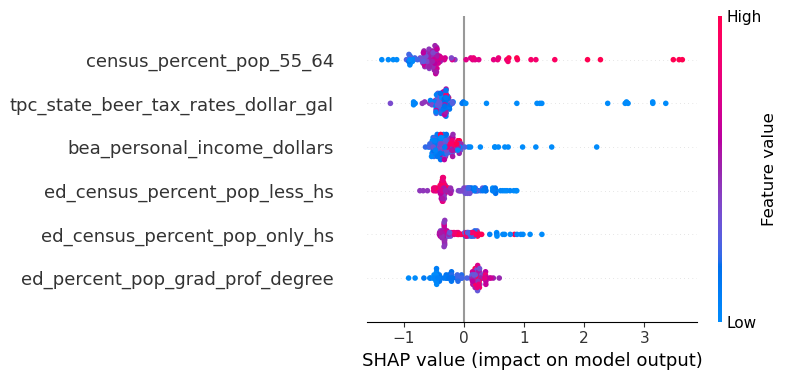

In [9]:
# Transform the datasets and create DataFrames with correct feature names
transformed_feature_names = numerical_features + percentage_features + binary_features

X_train_transformed = best_pipeline.named_steps['preprocessor'].transform(X_train)
X_test_transformed = best_pipeline.named_steps['preprocessor'].transform(X_test)

# Convert the transformed data back to DataFrames to retain feature names
X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=transformed_feature_names)
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=transformed_feature_names)

# Initialize the SHAP Explainer with the model using the DataFrame (which includes feature names)
explainer = shap.Explainer(best_pipeline.named_steps['regressor'], X_train_transformed_df)

# Calculate SHAP values for the test set transformed DataFrame
shap_values = explainer(X_test_transformed_df)

# Summary plot with correct feature names
shap_features = 6
shap.summary_plot(shap_values, X_test_transformed_df, max_display = shap_features, feature_names=transformed_feature_names)